# Brazillian Houses to Rent Dataset

Os dados foram obtidos através de um WebCrawler que captura informações relativas as características de imóveis e o valor do aluguel.

In [1]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import pickle 
import shap
from scipy import stats

from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Funções
def qualitativas(x, y):
    print('Variável: ' + x)
    print(data[x].value_counts(normalize = True).round(2))
    print('\n')
    print('Variável: ' + y)
    print(data[y].value_counts(normalize = True).round(2))
    print('\n')

    fig, axs = plt.subplots(ncols = 2, figsize=(15,6))
    sns.countplot(data[x], ax = axs[0], order = data[x].value_counts().index, palette = 'Blues_r')
    sns.countplot(data[y], ax = axs[1], order = data[y].value_counts().index, palette = 'Greens_r')
    
    
def quantitativas_discretas(x):
    print('Variável: ' + x)
    print(data[x].describe())
    print('\n')

    fig, axs = plt.subplots(ncols = 2, figsize = (15,6))
    sns.countplot(data[x], ax = axs[0])
    sns.boxplot(data = data, y = x, palette = 'Blues_r', ax = axs[1])
    
def quantitativas_continuas(x):
    print('Variável: ' + x)
    print(data[x].describe())
    print('\n')

    fig, axs = plt.subplots(ncols = 2, figsize = (15,6))
    sns.distplot(data[x], ax = axs[0])
    sns.boxplot(data = data, y = x, palette = 'Blues_r', ax = axs[1])
    

def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

def print_ecdf(x):
    plt.figure(figsize = (6, 6))
    rand_normal1 = data[x]
    x,y = ecdf(rand_normal1)  
    plt.scatter(x = x, y = y)
    plt.ylabel('Distribuição da Base', fontsize = 12)
    
    
def relacao_target(w, x):
    print('Média de valor total para variável ' + w)
    print(data[[w, 'total']].groupby(w).mean().reset_index().sort_values('total', ascending = False))
    print('\n')
    print('Média de valor total para variável ' + x)
    print(data[[x, 'total']].groupby(x).mean().reset_index().sort_values('total', ascending = False))
    print('\n')
    
    fig, axs = plt.subplots(ncols = 2, figsize=(15,6))
    sns.boxplot(data = data, x = w, y = 'total', ax = axs[0], palette = 'Blues_r')
    sns.boxplot(data = data, x = x, y = 'total', ax = axs[1], palette = 'Greens_r')
    
    
def correlacao(w, x, y):
    print('Tabela de correlação:')
    print(data[[w, x, y, 'total']].corr())
    print('\n')
    
    fig, axs = plt.subplots(ncols = 3, figsize=(24,6))
    sns.scatterplot(data = data, x = w, y = 'total', ax = axs[0], color = 'Blue')
    sns.scatterplot(data = data, x = x, y = 'total', ax = axs[1], color = 'Green')
    sns.scatterplot(data = data, x = y, y = 'total', ax = axs[2], color = 'Red')
    
    
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    data_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return data_out


def avaliacao_regressor(data):
    MAE = cross_val_score(data, x_test, y_test, cv = 5, scoring = 'neg_mean_absolute_error')
    MSE = cross_val_score(data, x_test, y_test, cv = 5, scoring = 'neg_mean_squared_error')
    SQRT_MSE = cross_val_score(data, x_test, y_test, cv = 5, scoring = 'neg_root_mean_squared_error')
    R2 = cross_val_score(data, x_test, y_test, cv = 5, scoring = 'r2')
    
    print('MAE: ' + str(np.mean(MAE)))
    print('MSE: ' + str(np.mean(MSE)))
    print('SQRT MSE: ' + str(np.mean(SQRT_MSE)))
    print('R2: ' + str(np.mean(R2)))

In [3]:
# Importação do dataset e ajuste no nome de algumas variáveis
data = pd.read_csv('datasets_554905_1035602_houses_to_rent_v2.csv').rename(columns = {'hoa (R$)': 'hoa',
                                                                                      'rent amount (R$)': 'rent_amount',
                                                                                      'property tax (R$)': 'property_tax',
                                                                                      'fire insurance (R$)': 'fire_insurance',
                                                                                      'total (R$)': 'total'})

In [4]:
data.sample(3)

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
4950,Porto Alegre,60,2,1,1,-,acept,not furnished,0,540,0,10,550
9483,São Paulo,200,3,3,2,7,acept,not furnished,4200,7225,642,92,12160
1391,São Paulo,96,3,2,2,19,acept,not furnished,480,2300,250,30,3060


- city: Cidade onde o imóvel está localizada
- area: Area do imovel
- rooms: Numero de quartos
- bathroom: Numero de banheiros
- parking spaces: Numero de vagas de garagem
- floor: Andar
- animal: Aceita animais?
- furniture: Mobilhada?
- hoa: Valor do condomínio
- rent amount: Valor do Aluguel
- property tax: IPTU
- fire insurance: Seguro Incendio
- total: Valor total

In [5]:
# Linhas e colunas
data.shape

(10692, 13)

In [6]:
# Verificação de dados vazios
data.isnull().sum()

city              0
area              0
rooms             0
bathroom          0
parking spaces    0
floor             0
animal            0
furniture         0
hoa               0
rent_amount       0
property_tax      0
fire_insurance    0
total             0
dtype: int64

In [7]:
# Verifica os tipos de dados
data.dtypes

city              object
area               int64
rooms              int64
bathroom           int64
parking spaces     int64
floor             object
animal            object
furniture         object
hoa                int64
rent_amount        int64
property_tax       int64
fire_insurance     int64
total              int64
dtype: object

# Detecção e remoção de outliers

O intervalo interquartil (IQR), também chamado de médio ou médio 50%, ou tecnicamente espalhado em H, é uma medida de dispersão estatística, sendo igual à diferença entre os percentis 75 e 25, ou entre os quartis superior e inferior, IQR = Q3 Q1.
Em outras palavras, o IQR é o primeiro quartil subtraído do terceiro quartil; esses quartis podem ser vistos claramente em um gráfico de caixa nos dados.


É uma medida da dispersão semelhante ao desvio ou variância padrão, mas é muito mais robusta em relação aos valores extremos.
O IQR é um pouco semelhante ao Z-score em termos de encontrar a distribuição dos dados e, em seguida, manter algum limite para identificar os valores extremos.

In [8]:
data.shape

(10692, 13)

In [9]:
data = remove_outlier(data, 'area')
data = remove_outlier(data, 'rooms')
data = remove_outlier(data, 'bathroom')
data = remove_outlier(data, 'parking spaces')
data = remove_outlier(data, 'hoa')
data = remove_outlier(data, 'rent_amount')
data = remove_outlier(data, 'property_tax')
data = remove_outlier(data, 'fire_insurance')
data = remove_outlier(data, 'total')

In [10]:
data.shape

(7346, 13)

# Análise Exploratória de Dados

Normalmente temos uma grande diferença no valor do aluguel entre cidades, por conta disso, iremos realizar essa verificação para definição se utilizaremos todas as cidades ou apenas São Paulo.

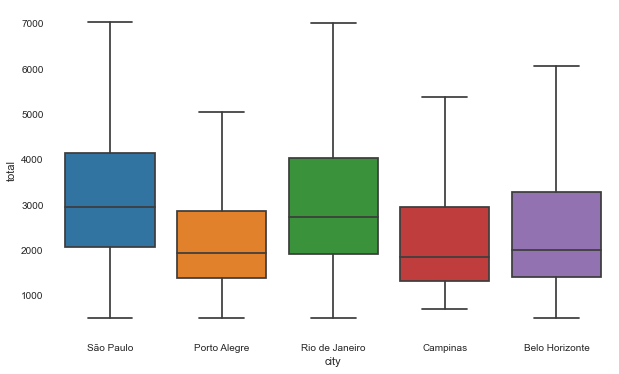

In [11]:
plt.figure(figsize=(10,6))
sns.boxplot(data = data, x = 'city', y = 'total', showfliers = False)

In [12]:
data = data[(data['city'] == 'São Paulo')]
data.shape

(3489, 13)

## Qualitativas

Variável: animal
acept        0.72
not acept    0.28
Name: animal, dtype: float64


Variável: furniture
not furnished    0.76
furnished        0.24
Name: furniture, dtype: float64




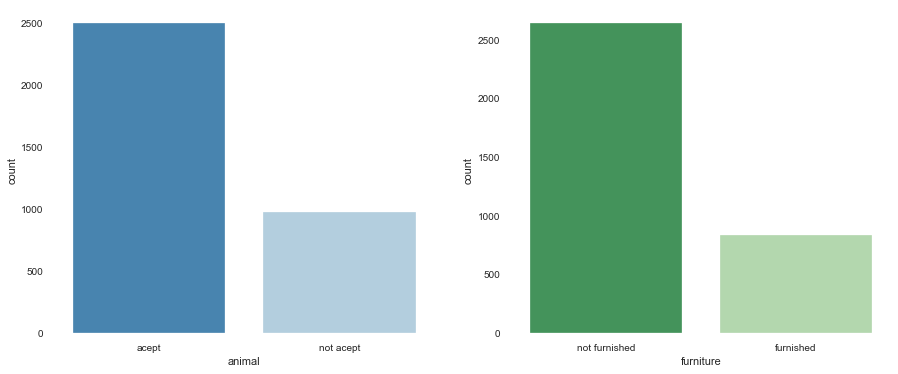

In [13]:
qualitativas('animal', 'furniture')

## Quantitativas Discretas

Variável: rooms
count    3489.000000
mean        1.966753
std         0.848323
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: rooms, dtype: float64




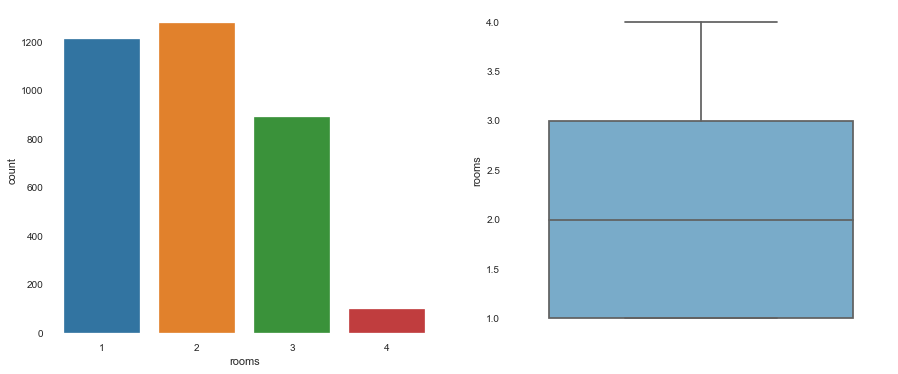

In [14]:
# Rooms
quantitativas_discretas('rooms')

Variável: bathroom
count    3489.000000
mean        1.608484
std         0.822419
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: bathroom, dtype: float64




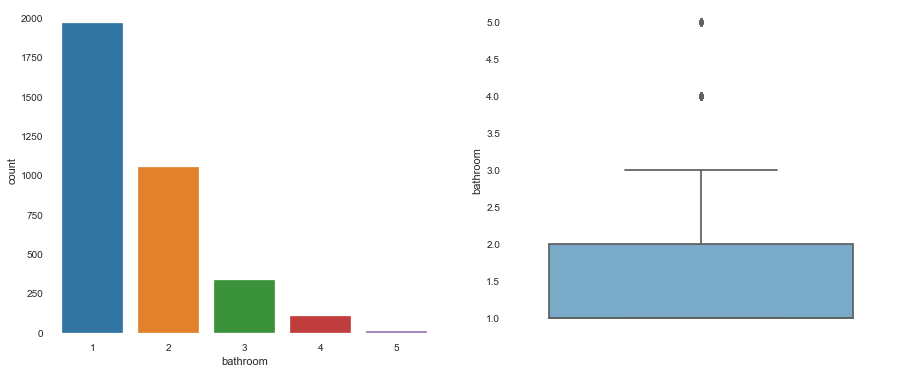

In [15]:
# Rooms
quantitativas_discretas('bathroom')

Variável: parking spaces
count    3489.000000
mean        1.002866
std         0.897878
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: parking spaces, dtype: float64




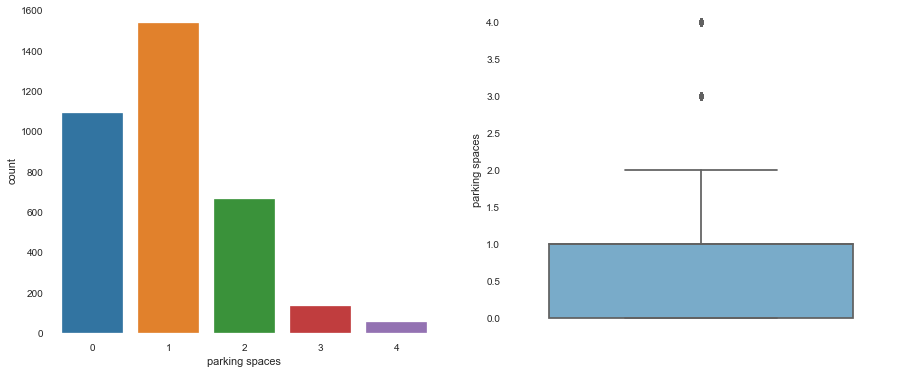

In [16]:
# Parking Spaces
quantitativas_discretas('parking spaces')

Variável: floor
count    3489.000000
mean        5.479507
std         5.784916
min         0.000000
25%         1.000000
50%         4.000000
75%         9.000000
max        32.000000
Name: floor, dtype: float64




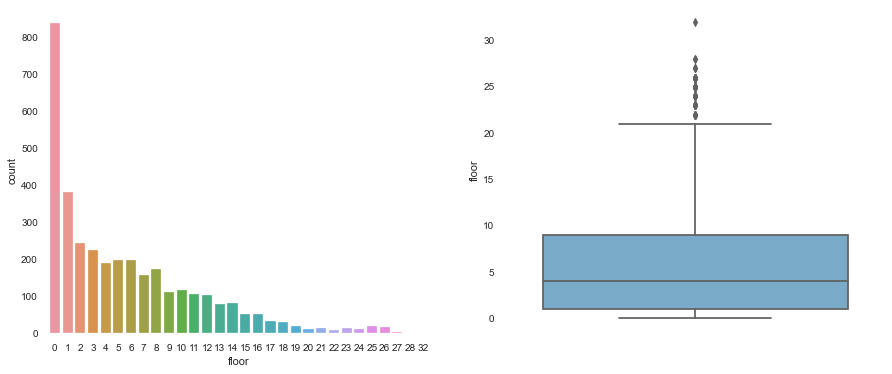

In [17]:
# Floor
data['floor'] = np.where(data['floor'] == '-', 0, data['floor']).astype(int)
quantitativas_discretas('floor')

## Quantitativas Contínuas

Variável: area
count    3489.000000
mean       79.775867
std        50.692251
min        11.000000
25%        45.000000
50%        67.000000
75%       100.000000
max       350.000000
Name: area, dtype: float64




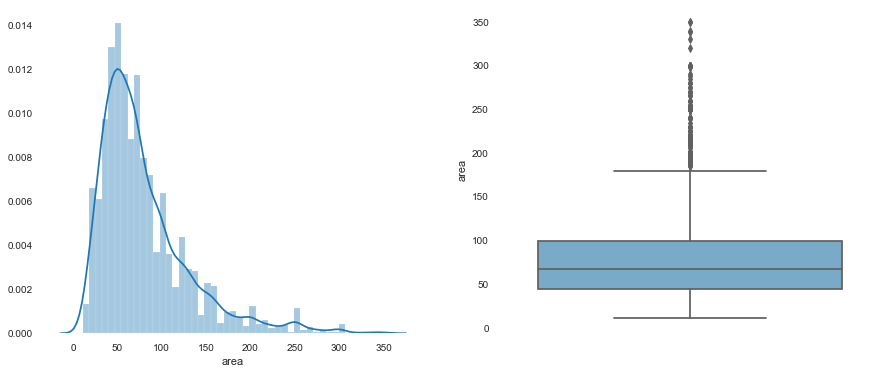

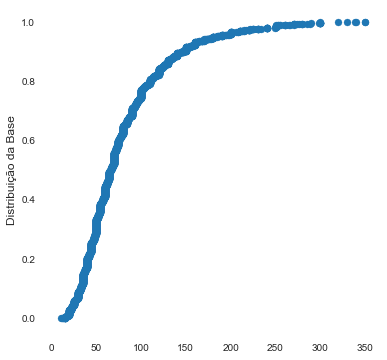

In [18]:
quantitativas_continuas('area')
print_ecdf('area')

Variável: hoa
count    3489.000000
mean      585.912869
std       521.020342
min         0.000000
25%        50.000000
50%       515.000000
75%       870.000000
max      2600.000000
Name: hoa, dtype: float64




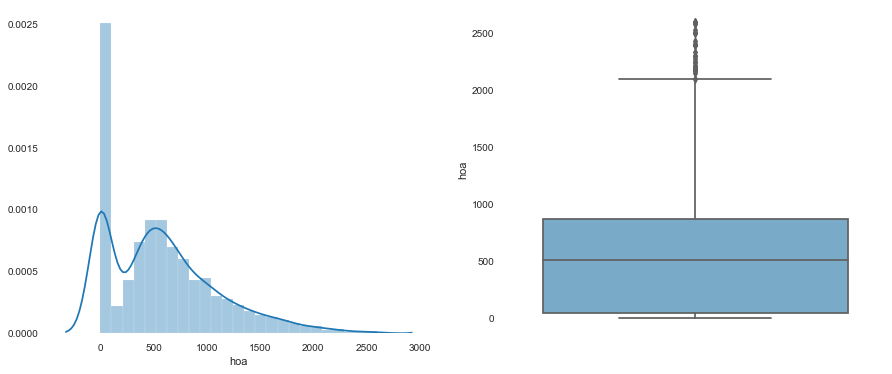

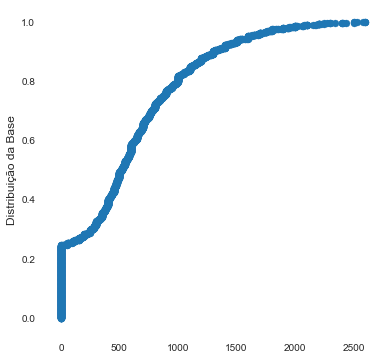

In [19]:
quantitativas_continuas('hoa')
print_ecdf('hoa')

Variável: rent_amount
count    3489.000000
mean     2466.746346
std      1112.403206
min       500.000000
25%      1600.000000
50%      2210.000000
75%      3200.000000
max      6000.000000
Name: rent_amount, dtype: float64




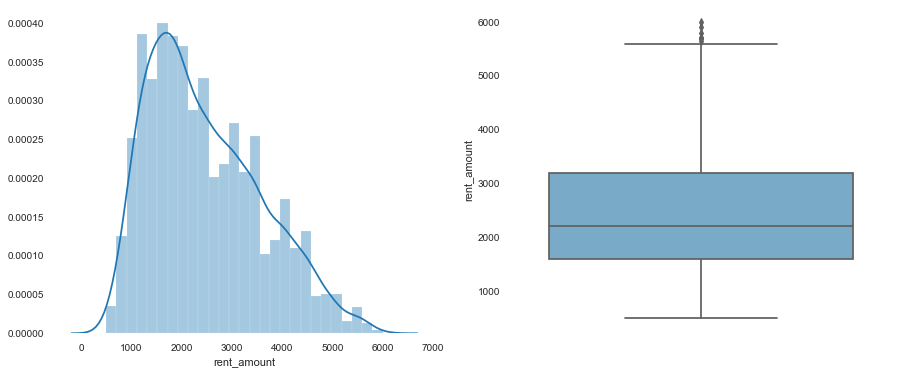

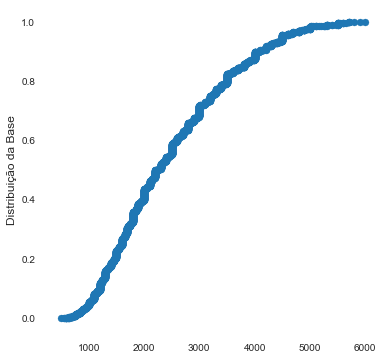

In [20]:
quantitativas_continuas('rent_amount')
print_ecdf('rent_amount')

Variável: property_tax
count    3489.000000
mean      108.223846
std       115.445033
min         0.000000
25%         1.000000
50%        72.000000
75%       167.000000
max       480.000000
Name: property_tax, dtype: float64




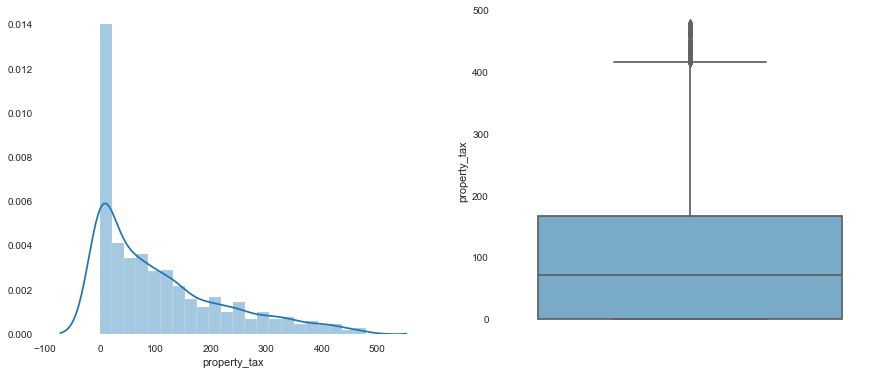

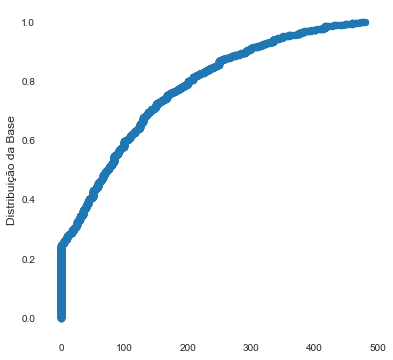

In [21]:
quantitativas_continuas('property_tax')
print_ecdf('property_tax')

Variável: fire_insurance
count    3489.000000
mean       32.626827
std        15.007434
min         4.000000
25%        21.000000
50%        30.000000
75%        42.000000
max        75.000000
Name: fire_insurance, dtype: float64




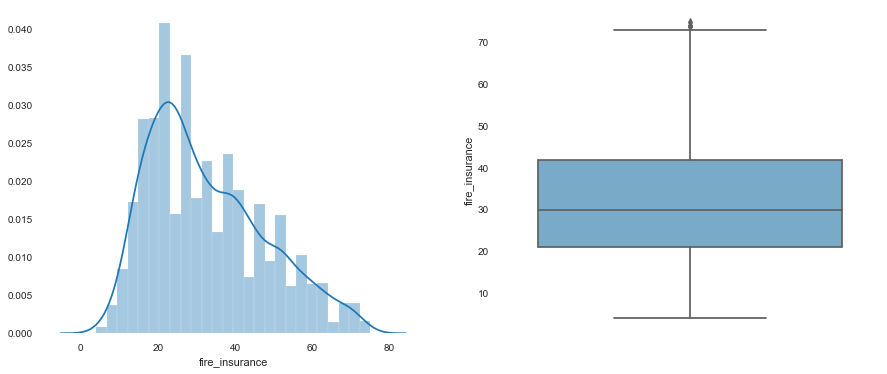

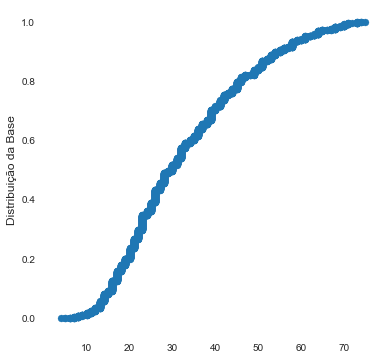

In [22]:
quantitativas_continuas('fire_insurance')
print_ecdf('fire_insurance')

Variável: total
count    3489.000000
mean     3193.792777
std      1456.245136
min       508.000000
25%      2071.000000
50%      2964.000000
75%      4145.000000
max      7036.000000
Name: total, dtype: float64




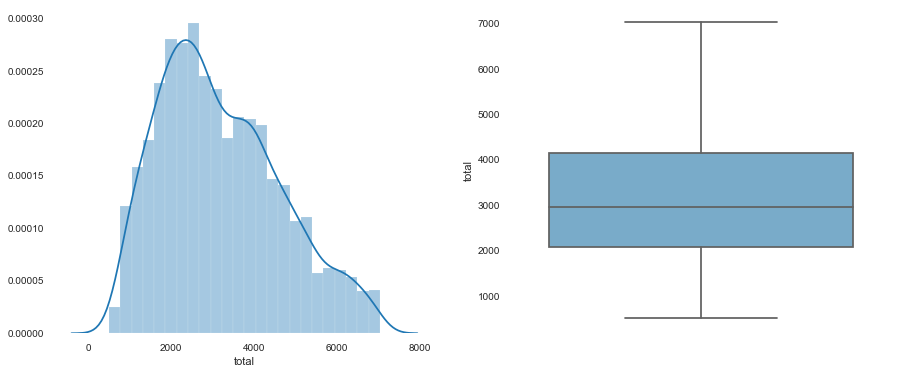

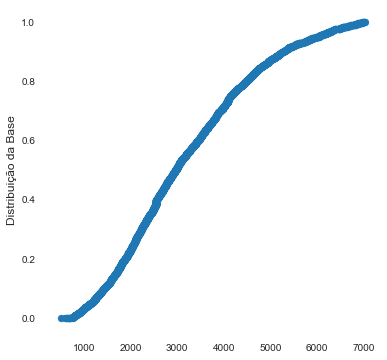

In [23]:
quantitativas_continuas('total')
print_ecdf('total')

# Análise Multivariada

Média de valor total para variável animal
      animal        total
0      acept  3278.999202
1  not acept  2976.264766


Média de valor total para variável furniture
       furniture        total
0      furnished  3938.402381
1  not furnished  2957.676482




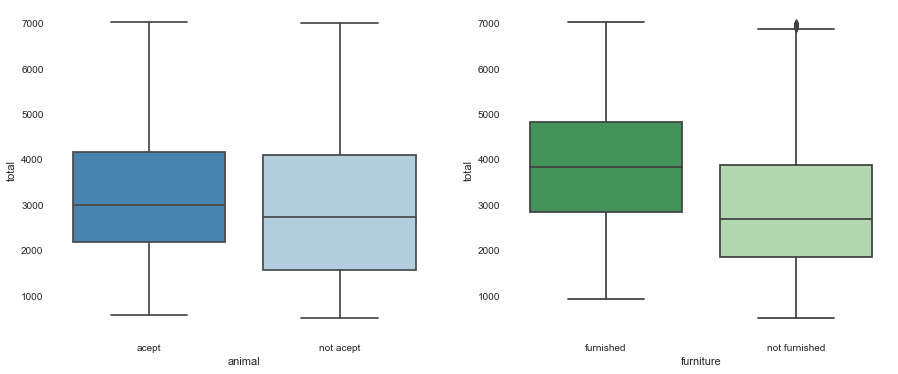

In [24]:
relacao_target('animal', 'furniture')

Média de valor total para variável rooms
   rooms        total
3      4  4521.911765
2      3  3960.079507
1      2  3004.098361
0      1  2718.307502


Média de valor total para variável bathroom
   bathroom        total
4         5  5183.062500
3         4  4545.018182
2         3  4369.452663
1         2  3763.781576
0         1  2596.412272




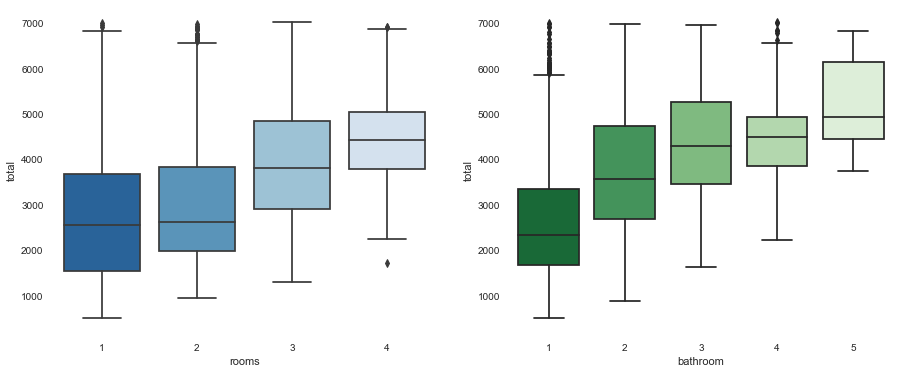

In [25]:
relacao_target('rooms', 'bathroom')

Média de valor total para variável parking spaces
   parking spaces        total
3               3  4299.977444
4               4  4068.344828
2               2  4020.832831
1               1  3367.079870
0               0  2267.043876


Média de valor total para variável floor
    floor        total
28     28  6507.000000
27     27  5365.666667
20     20  5006.545455
21     21  4467.000000
24     24  4075.363636
14     14  4068.926829
13     13  3903.037500
11     11  3826.242991
12     12  3772.951923
10     10  3760.051724
29     32  3758.000000
17     17  3740.545455
19     19  3726.850000
8       8  3724.017341
22     22  3714.125000
18     18  3632.774194
7       7  3615.563291
9       9  3556.562500
6       6  3553.777778
16     16  3553.215686
15     15  3510.392157
23     23  3505.846154
4       4  3496.619048
5       5  3372.604061
25     25  3298.052632
3       3  3181.600000
2       2  3162.697959
26     26  2921.625000
1       1  2649.057743
0       0  2467.389750




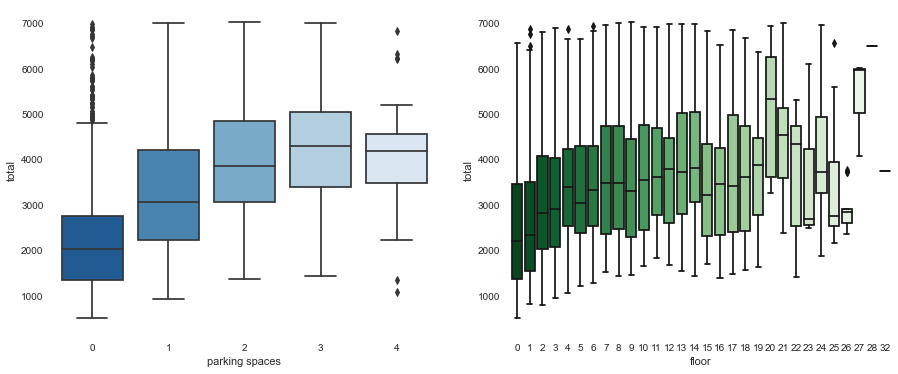

In [26]:
relacao_target('parking spaces', 'floor')

Tabela de correlação:
                 area       hoa  rent_amount     total
area         1.000000  0.127058     0.436877  0.418800
hoa          0.127058  1.000000     0.349433  0.659303
rent_amount  0.436877  0.349433     1.000000  0.931853
total        0.418800  0.659303     0.931853  1.000000




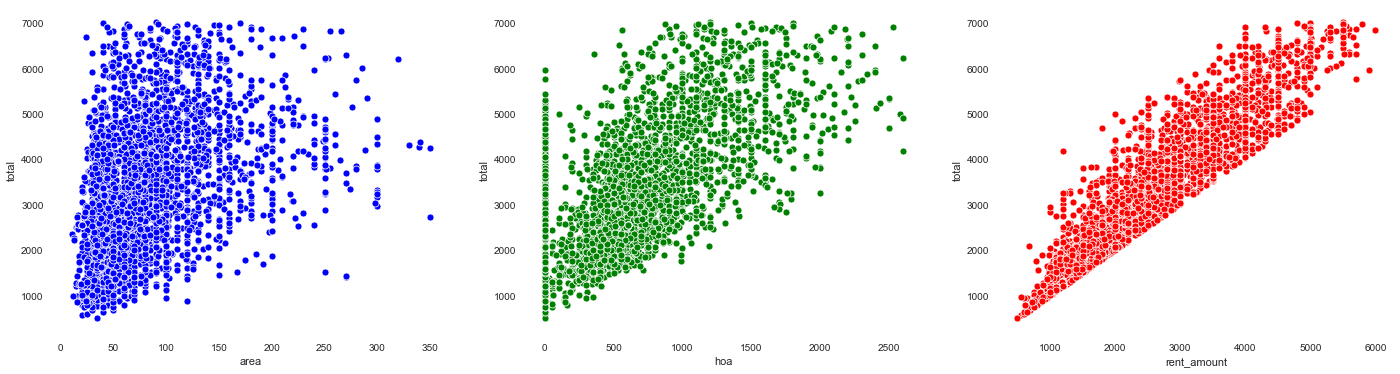

In [27]:
correlacao('area', 'hoa', 'rent_amount')

Tabela de correlação:
                property_tax  fire_insurance     total     total
property_tax        1.000000        0.428609  0.547313  0.547313
fire_insurance      0.428609        1.000000  0.868534  0.868534
total               0.547313        0.868534  1.000000  1.000000
total               0.547313        0.868534  1.000000  1.000000




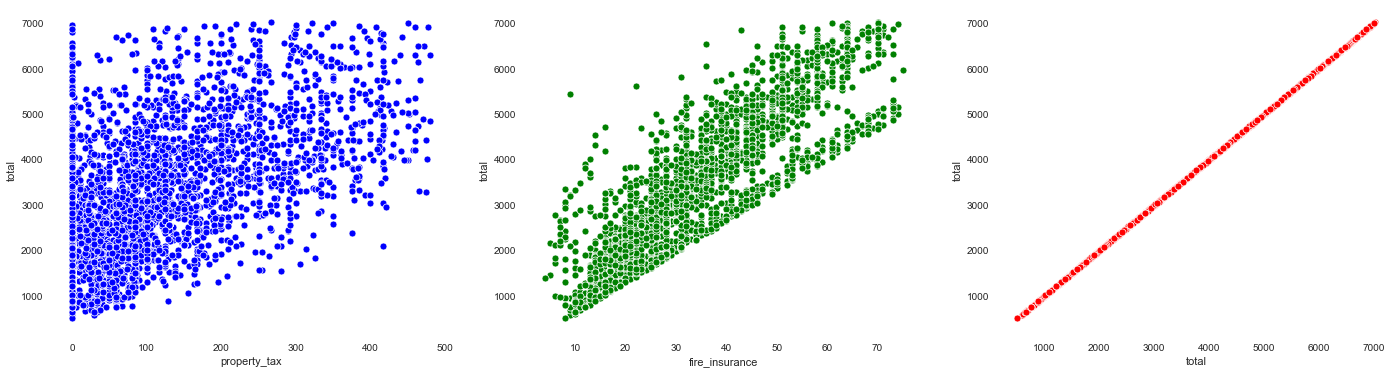

In [28]:
correlacao('property_tax', 'fire_insurance', 'total')

# Construção do Modelo de Regressão Linear

### Modelo Base

In [29]:
# Transforma as variáveis categóricas em dummy
data_model = data.copy().rename(columns = {'parking spaces': 'parking_spaces'})

In [30]:
# Binarização em variáveis com apenas 2 categorias.
data_model['animal'] = np.where(data_model['animal'] == 'acept', 1, 0)
data_model['furniture'] = np.where(data_model['furniture'] == 'furnished', 1, 0)

In [31]:
# Preenchimento da variável 'hoa' com a mediana
# Não preencheremos a variável 'property_tax' pois não são todas as moradias que possuem condomínio
data_model['hoa'] = np.where(data_model['hoa'] == 0, np.nan, data_model['hoa'])
data_model['hoa'] = data_model['hoa'].fillna(data_model['hoa'].median())

In [32]:
data_model.sample(5)

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
2604,São Paulo,80,2,1,0,0,0,0,660.0,1576,125,24,1725
5333,São Paulo,54,2,2,1,2,1,0,400.0,1927,100,12,2439
10074,São Paulo,50,1,1,0,2,0,0,150.0,720,0,10,880
3230,São Paulo,41,1,1,1,4,0,1,380.0,3220,0,13,3613
2568,São Paulo,96,2,1,0,9,1,1,940.0,4387,3,56,5386


In [33]:
# Separa entre variáveis preditoras e target
x = data_model.iloc[:, 1:12]
y = data_model.iloc[:, 12]

In [34]:
# Normalização
std = MinMaxScaler()
std.fit(x)
x = std.transform(x)

In [35]:
# Treina o modelo com todas as variáveis, com exceção da 'rend_amount' e 'fire_insurance', pois possuem uma correção muito forte
# com a variável target, indicando multicolinearidade.
lm = smf.ols(formula='total ~ area + rooms + bathroom + parking_spaces + floor + animal + furniture + hoa + property_tax', data = data_model).fit()

In [36]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     621.9
Date:                Wed, 08 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:34:40   Log-Likelihood:                -28690.
No. Observations:                3489   AIC:                         5.740e+04
Df Residuals:                    3479   BIC:                         5.746e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        576.9410     51.682     11.

### Criação do Modelo sem variáveis com p-value acima de 0.05

In [37]:
# Separa entre variáveis preditoras e target
# Além das variáveis removidas por multicolinearidade, removemos a variável 'rooms' por conter p-value acima de 0.05
x = data_model[['area', 'bathroom', 'parking_spaces', 'floor', 'animal', 'furniture', 'hoa', 'property_tax']]
y = data_model[['total']]

In [38]:
# Separação em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 1)

In [39]:
# Criação do modelo
lm2 = LinearRegression()
lm2.fit(x_train, y_train)

# Predict
y_pred = lm2.predict(x_test)

# Print das métricas de avaliação
avaliacao_regressor(lm2)

MAE: -680.0569131244149
MSE: -752559.259432577
SQRT MSE: -866.6024210064336
R2: 0.6531547119343948


In [40]:
# Print dos coeficientes
coefficients = pd.concat([pd.DataFrame(x.columns),pd.DataFrame(np.transpose(lm2.coef_))], axis = 1)
coefficients

,0,0
0,area,4.345684
1,bathroom,231.001175
2,parking_spaces,118.748997
3,floor,60.124046
4,animal,48.350069
5,furniture,816.185846
6,hoa,1.214212
7,property_tax,2.326804


## Criação de um Gradient Boosting Classifier

In [41]:
# Criação do modelo
gb = GradientBoostingRegressor()
gb.fit(x_train, y_train)

# Predict
y_pred = gb.predict(x_test)

avaliacao_regressor(gb)

MAE: -625.9885613177732
MSE: -701997.4346184543
SQRT MSE: -838.3131016913565
R2: 0.6754320218333862


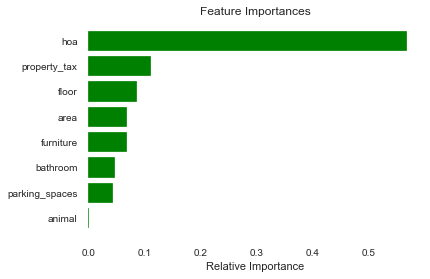

In [42]:
# Print da importância de cada feature para o modelo
importances = gb.feature_importances_
indices = np.argsort(importances)
features = x_train.columns

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color = 'g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

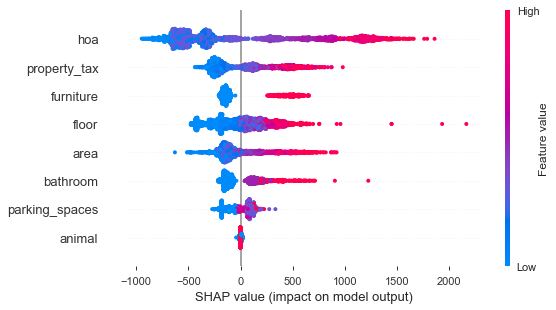

In [43]:
# SHAP
shap_values = shap.TreeExplainer(gb).shap_values(x_train)
shap.summary_plot(shap_values, x_train)

## Criação do Modelo de Random Forest com Hyperparameter Tuning

In [44]:
# Criação dos parâmetros

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [46]:
# Criação do modelo
gb_2 = GradientBoostingRegressor()
gb_random = RandomizedSearchCV(estimator = gb_2, param_distributions = random_grid, n_iter = 100, cv = 5, verbose = 2, random_state = 1, n_jobs = -1)
gb_random.fit(x_train, y_train)

# Print dos melhores parâmetros
gb_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 23.8min finished


{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20}

In [47]:
# Criação do modelo
gb_3 = GradientBoostingRegressor(n_estimators = 1200,
                                 min_samples_split = 2,
                                 min_samples_leaf = 1,
                                 max_features = 'sqrt',
                                 max_depth = 20)
gb_3.fit(x_train, y_train)

# Predict
y_pred = gb_3.predict(x_test)

avaliacao_regressor(gb_3)

# Aumento de 8,6% em relação ao R2 do modelo base

MAE: -642.1095612814596
MSE: -731907.1545221008
SQRT MSE: -855.8254776906253
R2: 0.6637485495368958


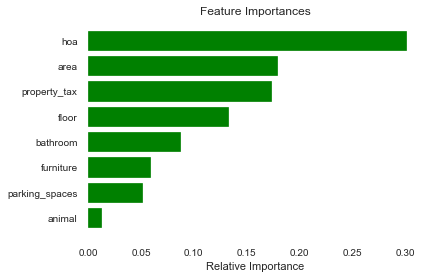

In [48]:
# Print da importância de cada feature para o modelo
importances = gb_3.feature_importances_
indices = np.argsort(importances)
features = x_train.columns

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color = 'g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

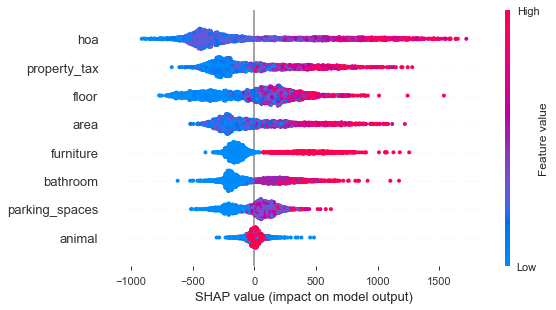

In [49]:
# SHAP
shap_values = shap.TreeExplainer(gb_3).shap_values(x_train)
shap.summary_plot(shap_values, x_train)

### Salva o artefato do modelo

In [50]:
filename = 'AluguelPrevisto_GB_v1.sav'
pickle.dump(gb, open(filename, 'wb'))